## Variable selection 4: Random Forest drop-column variable importance + variable dependance

This notebook goes with the blog post: [Variable selection in Python, part I](https://mycarta.wordpress.com/2019/04/30/variable-selection-in-python-part-i/).

### Code adapted from the `rfpimp` [package](https://github.com/parrt/random-forest-importances)

### Reference article: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)


### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from rfpimp import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

### Data loading, dropping production

In [3]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [4]:
data = data.loc[:, ['Production', 'Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform']]
data.head()

,Production,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,15.10,2.1,0.1,0.5,19,5,379,3.54
1,21.30,1.1,1.0,4.0,16,13,269,5.79
2,22.75,1.0,1.9,19.0,14,12,245,8.51
3,15.72,2.1,3.1,21.7,17,6,273,11.52
4,7.71,2.9,4.1,24.6,11,10,237,10.16


### Built-in scikit importances

In [5]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True)

X_train, y_train = data.drop('Production',axis=1), data['Production']
rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)

I = mkdf(X_train.columns,rf.feature_importances_)            

0.839799247935496


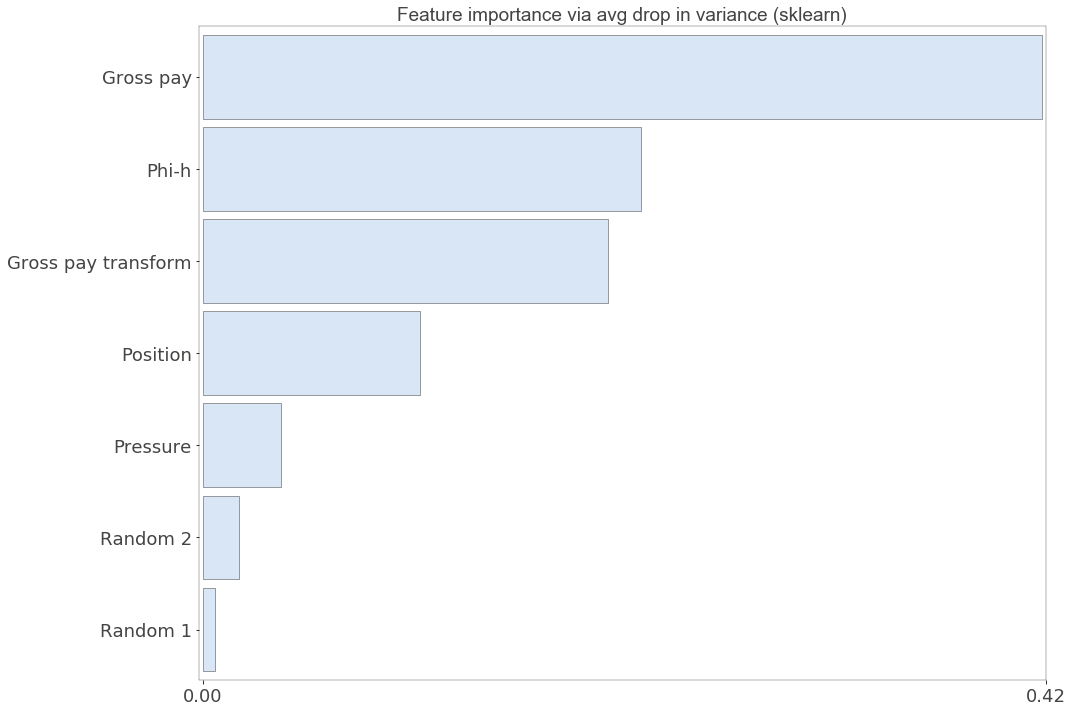

In [6]:
viz = plot_importances(I, title="Feature importance via avg drop in variance (sklearn)", 
                       label_fontsize=18, minheight=10, width=15)

### Examine cost of dropping columns

In [7]:
from sklearn.base import clone

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    return np.array(imp)

In [8]:
base_rf = RandomForestRegressor(n_estimators=100,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                oob_score=True,
                                random_state = 999) # same boostrapping samples

X_train, y_train = data.drop('Production',axis=1), data['Production']
rf = clone(base_rf)

imp = dropcol_importances(rf, X_train, y_train)
I = mkdf(X_train.columns,imp)


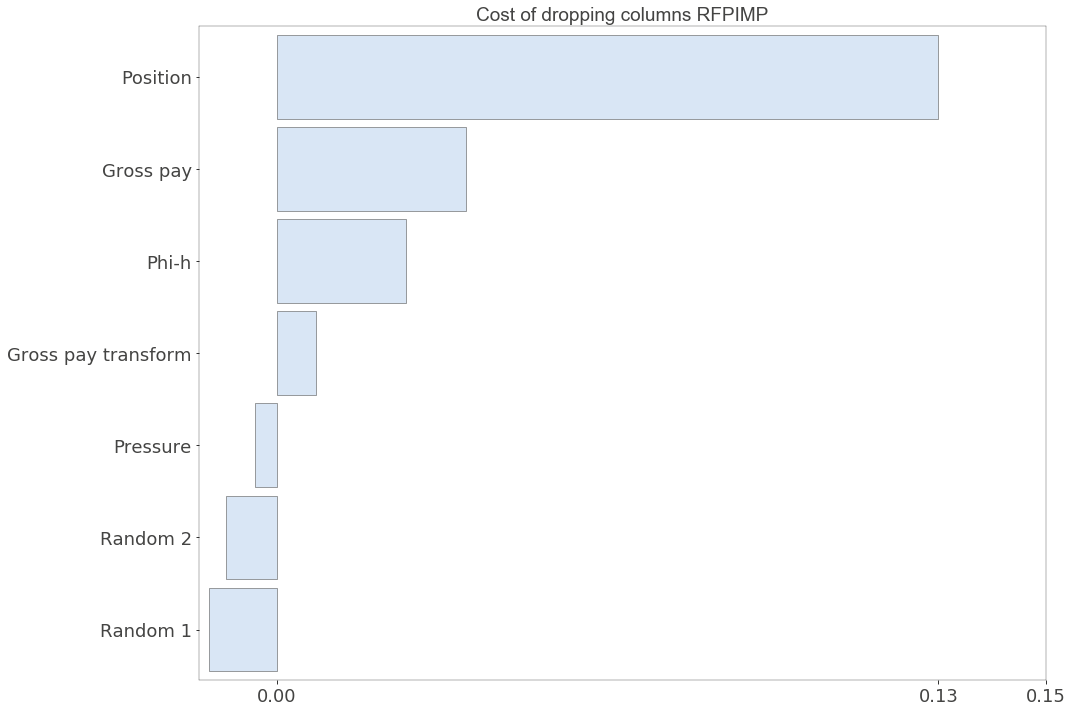

In [9]:
viz = plot_importances(I, title="Cost of dropping columns RFPIMP", 
                       label_fontsize=18, minheight=10, width=15)

### Multicollinearity

In [10]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [11]:
print('Dependence:')
print(D['Dependence'].sort_values(ascending=False).to_string())

Dependence:
Gross pay               0.939
Gross pay transform     0.815
Phi-h                   0.503
Random 2               0.0789
Position               0.0745
Pressure               -0.396
Random 1               -0.836


### Remove Gross pay and repeat

In [12]:
X_train1=X_train.drop(columns=['Gross pay'])
X_train1.head()

,Position,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
0,2.1,0.5,19,5,379,3.54
1,1.1,4.0,16,13,269,5.79
2,1.0,19.0,14,12,245,8.51
3,2.1,21.7,17,6,273,11.52
4,2.9,24.6,11,10,237,10.16


In [13]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train1, sort_by_dependence=True)

In [14]:
print('Dependence:')
print(D['Dependence'].sort_values(ascending=False).to_string())

Dependence:
Gross pay transform     0.479
Phi-h                   0.429
Position                0.146
Random 2              -0.0522
Pressure               -0.319
Random 1               -0.457


### This time remove Gross pay transform and repeat

In [15]:
X_train2=X_train.drop(columns=['Gross pay transform'])
X_train2.head()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2
0,2.1,0.1,0.5,19,5,379
1,1.1,1.0,4.0,16,13,269
2,1.0,1.9,19.0,14,12,245
3,2.1,3.1,21.7,17,6,273
4,2.9,4.1,24.6,11,10,237


In [16]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train2, sort_by_dependence=True)

In [17]:
print('Dependence:')
print(D['Dependence'].sort_values(ascending=False).to_string())

Dependence:
Gross pay    0.594
Phi-h        0.573
Random 2     0.179
Position     0.106
Pressure    -0.339
Random 1    -0.767
